## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold

## Prepare data for model training

In [2]:
with open("../input/mathcothon-i-shalt-prepareth-data/MathCoThon_Ready_Meatballs.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

0

In [3]:
cat_cols = ['Manufacturer','Model','Category','Leather interior','Cylinders',
            'Doors','Wheel','Color','Airbags','Turbo_Engine','Leap_Year',
            'Hybrid_Car','Numbers_in_Model','Drive wheels Front','Drive wheels Rear',
            'Manual_Gear','Automatic_Gear','Continuous_Gear','Fuel Tank Petrol',
            'Fuel Tank Diesel','Fuel Tank Gas','id0','id1','id2','id3','id4','id5','id6','id7']

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)
cat_cols_indices = [train_df.columns.get_loc(col) for col in cat_cols]
print(cat_cols_indices)

[1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 27, 29, 25, 38, 39, 35, 36, 37, 30, 31, 32, 13, 14, 15, 16, 17, 18, 19, 20]


In [4]:
Xtrain = train_df.loc[:, ~train_df.columns.isin(['Price'])].copy()
Ytrain = train_df['Price'].copy()
Ytrain_strat = pd.qcut(np.log1p(train_df['Price']), q=10, labels=range(0,10))
Xtest = test_df.copy()

print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape))

del train_df
del test_df
gc.collect()

Xtrain: (15628, 893) 
Ytrain: (15628,) 
Xtest: (8245, 893)


20

## Build and validate the model

### Model-1

In [5]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp1 = 0
counter = 0
oof_score1 = 0
y_pred_meta_lgb1 = np.zeros((Ytrain.shape[0], 1))
y_pred_final_lgb1 = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = LGBMRegressor(
            boosting_type='gbdt', 
            num_leaves=1756, 
            max_depth=12, 
            learning_rate=0.0107, 
            n_estimators=5000,
            objective='regression', 
            min_child_samples=15, 
            subsample=0.875, 
            subsample_freq=7, 
            colsample_bytree=0.6995, 
            reg_lambda=0.00489,
            random_state=(seed+idx)
        )
        
        model.fit(train_x, train_y, eval_metric='rmse',
                  eval_set=(val_x, val_y),
                  early_stopping_rounds=200, verbose=1000,
                  categorical_feature=cat_cols_indices)

        y_pred = model.predict(val_x, num_iteration=model.best_iteration_)
        y_pred_meta_lgb1[val] += np.array([y_pred]).T
        y_pred_final_lgb1 += model.predict(Xtest, num_iteration=model.best_iteration_)
        
        score = np.sqrt(mean_squared_log_error(np.exp(val_y), np.exp(y_pred)))
        oof_score1 += score
        seed_score += score
        fet_imp1 += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lgb1 = y_pred_meta_lgb1 / float(len(SEEDS))
y_pred_final_lgb1 = y_pred_final_lgb1 / float(counter)
fet_imp1 = fet_imp1 / float(counter)
oof_score1 /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score1))

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.920375	valid_0's l2: 0.84709
Early stopping, best iteration is:
[1281]	valid_0's rmse: 0.919718	valid_0's l2: 0.84588
Seed-2020 | Fold-0 | OOF Score: 0.9174978132796793
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.891566	valid_0's l2: 0.79489
Early stopping, best iteration is:
[963]	valid_0's rmse: 0.890697	valid_0's l2: 0.793341
Seed-2020 | Fold-1 | OOF Score: 0.8891024679603562
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[649]	valid_0's rmse: 0.877103	valid_0's l2: 0.76931
Seed-2020 | Fold-2 | OOF Score: 0.8756261429944059
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.888102	valid_0's l2: 0.788725
Early stopping, best iteration is:
[1176]	valid_0's rmse: 0.886709	valid_0's l2: 0.786253
Seed-2020 | Fold-3 | OOF Score: 0.8849111504695619
Training until validation sco

### Model-2

In [6]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp2 = 0
counter = 0
oof_score2 = 0
y_pred_meta_lgb2 = np.zeros((Ytrain.shape[0], 1))
y_pred_final_lgb2 = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = LGBMRegressor(
            boosting_type='gbdt', 
            num_leaves=1546, 
            max_depth=11, 
            learning_rate=0.012, 
            n_estimators=5000, 
            objective='regression', 
            min_child_samples=14, 
            subsample=0.8196, 
            subsample_freq=9, 
            colsample_bytree=0.6256, 
            reg_lambda=0.0336, 
            random_state=(seed+idx)
        )
        
        model.fit(train_x, train_y, eval_metric='rmse',
                  eval_set=(val_x, val_y),
                  early_stopping_rounds=200, verbose=1000,
                  categorical_feature=cat_cols_indices)

        y_pred = model.predict(val_x, num_iteration=model.best_iteration_)
        y_pred_meta_lgb2[val] += np.array([y_pred]).T
        y_pred_final_lgb2 += model.predict(Xtest, num_iteration=model.best_iteration_)
        
        score = np.sqrt(mean_squared_log_error(np.exp(val_y), np.exp(y_pred)))
        oof_score2 += score
        seed_score += score
        fet_imp2 += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lgb2 = y_pred_meta_lgb2 / float(len(SEEDS))
y_pred_final_lgb2 = y_pred_final_lgb2 / float(counter)
fet_imp2 = fet_imp2 / float(counter)
oof_score2 /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score2))

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.92568	valid_0's l2: 0.856884
Early stopping, best iteration is:
[1201]	valid_0's rmse: 0.92475	valid_0's l2: 0.855162
Seed-2020 | Fold-0 | OOF Score: 0.9224954083541386
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.89303	valid_0's l2: 0.797503
Early stopping, best iteration is:
[1077]	valid_0's rmse: 0.892411	valid_0's l2: 0.796397
Seed-2020 | Fold-1 | OOF Score: 0.8908195765627644
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[594]	valid_0's rmse: 0.882617	valid_0's l2: 0.779013
Seed-2020 | Fold-2 | OOF Score: 0.881122442700239
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.894824	valid_0's l2: 0.800709
Early stopping, best iteration is:
[1106]	valid_0's rmse: 0.894317	valid_0's l2: 0.799803
Seed-2020 | Fold-3 | OOF Score: 0.892509688515767
Training until validation sco

In [7]:
np.savez_compressed('./LGB_Meta_Features.npz',
                    y_pred_meta_lgb1=y_pred_meta_lgb1,
                    y_pred_meta_lgb2=y_pred_meta_lgb2,
                    oof_score1=oof_score1,
                    oof_score2=oof_score2,
                    y_pred_final_lgb1=y_pred_final_lgb1,
                    y_pred_final_lgb2=y_pred_final_lgb2)

## Create submission file

In [8]:
y_pred_final_lgb = (y_pred_final_lgb1 + y_pred_final_lgb2) / 2.0

In [9]:
train_df = pd.read_csv("../input/mathcothon/train.csv")
test_df = pd.read_csv("../input/mathcothon/test.csv")

check_cols = [col for col in train_df.columns if col != 'ID']
train_df = train_df[~train_df.duplicated(subset=check_cols, keep='first')].copy()
print(f"Num records after Step-1: {train_df.shape[0]}")

check_cols = [col for col in train_df.columns if col not in ['ID','Price']]
train_df = train_df.groupby(check_cols).agg({'Price':'mean'}).reset_index().copy()
print(f"Num records after Step-2: {train_df.shape[0]}")

Num records after Step-1: 15725
Num records after Step-2: 15463


In [10]:
train_cols = [col for col in train_df.columns if col != 'ID']
test_cols = [col for col in test_df.columns if col not in ['ID','Price']]

df = pd.merge(
    test_df[test_cols], 
    train_df[train_cols], 
    how='left', 
    on=test_cols,
    sort=False
)

df = df.rename(columns={'Price': 'Train_Price'})
df['Predicted_Price'] = np.exp(y_pred_final_lgb)
df['Price'] = df.apply(lambda row: row['Predicted_Price'] if pd.isnull(row['Train_Price']) else row['Train_Price'], axis=1)
print(f"df: {df.shape}")
df.head()

df: (8245, 19)


,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Train_Price,Predicted_Price,Price
0,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN,11353.032406,11353.032406
1,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN,8251.521438,8251.521438
2,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN,9798.845639,9798.845639
3,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN,6702.816321,6702.816321
4,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN,3491.258483,3491.258483


In [11]:
df.loc[df['Manufacturer']=='TESLA','Price'] = 53941
df.loc[df['Manufacturer']=='SATURN','Price'] = 13799
df.loc[df['Manufacturer']=='ASTON MARTIN','Price'] = 54000
df.loc[(df['Manufacturer']=='GREATWALL')&(df['Model']=='C30'),'Price'] = 10036

df.loc[df['Prod. year']==1943,'Price'] = 119172
df.loc[df['Prod. year']==1968,'Price'] = 2200
df.loc[df['Prod. year']==1981,'Price'] = 2800

df.loc[df['Fuel type']=='Hydrogen','Price'] = 20385

df.loc[df['Engine volume']=='0.3 Turbo', 'Price'] = 6272
df.loc[df['Engine volume']=='0.5', 'Price'] = 1300
df.loc[df['Engine volume']=='0.8 Turbo', 'Price'] = 6272
df.loc[df['Engine volume']=='3.1', 'Price'] = 8781
df.loc[df['Engine volume']=='5.2', 'Price'] = 13000
df.loc[df['Engine volume']=='6.7', 'Price'] = 1019

In [12]:
submit_df = pd.DataFrame()
submit_df['Price'] = df['Price']
submit_df.to_csv("./LGB_Submission.csv", index=False)
submit_df.head()

,Price
0,11353.032406
1,8251.521438
2,9798.845639
3,6702.816321
4,3491.258483


## Features Importance

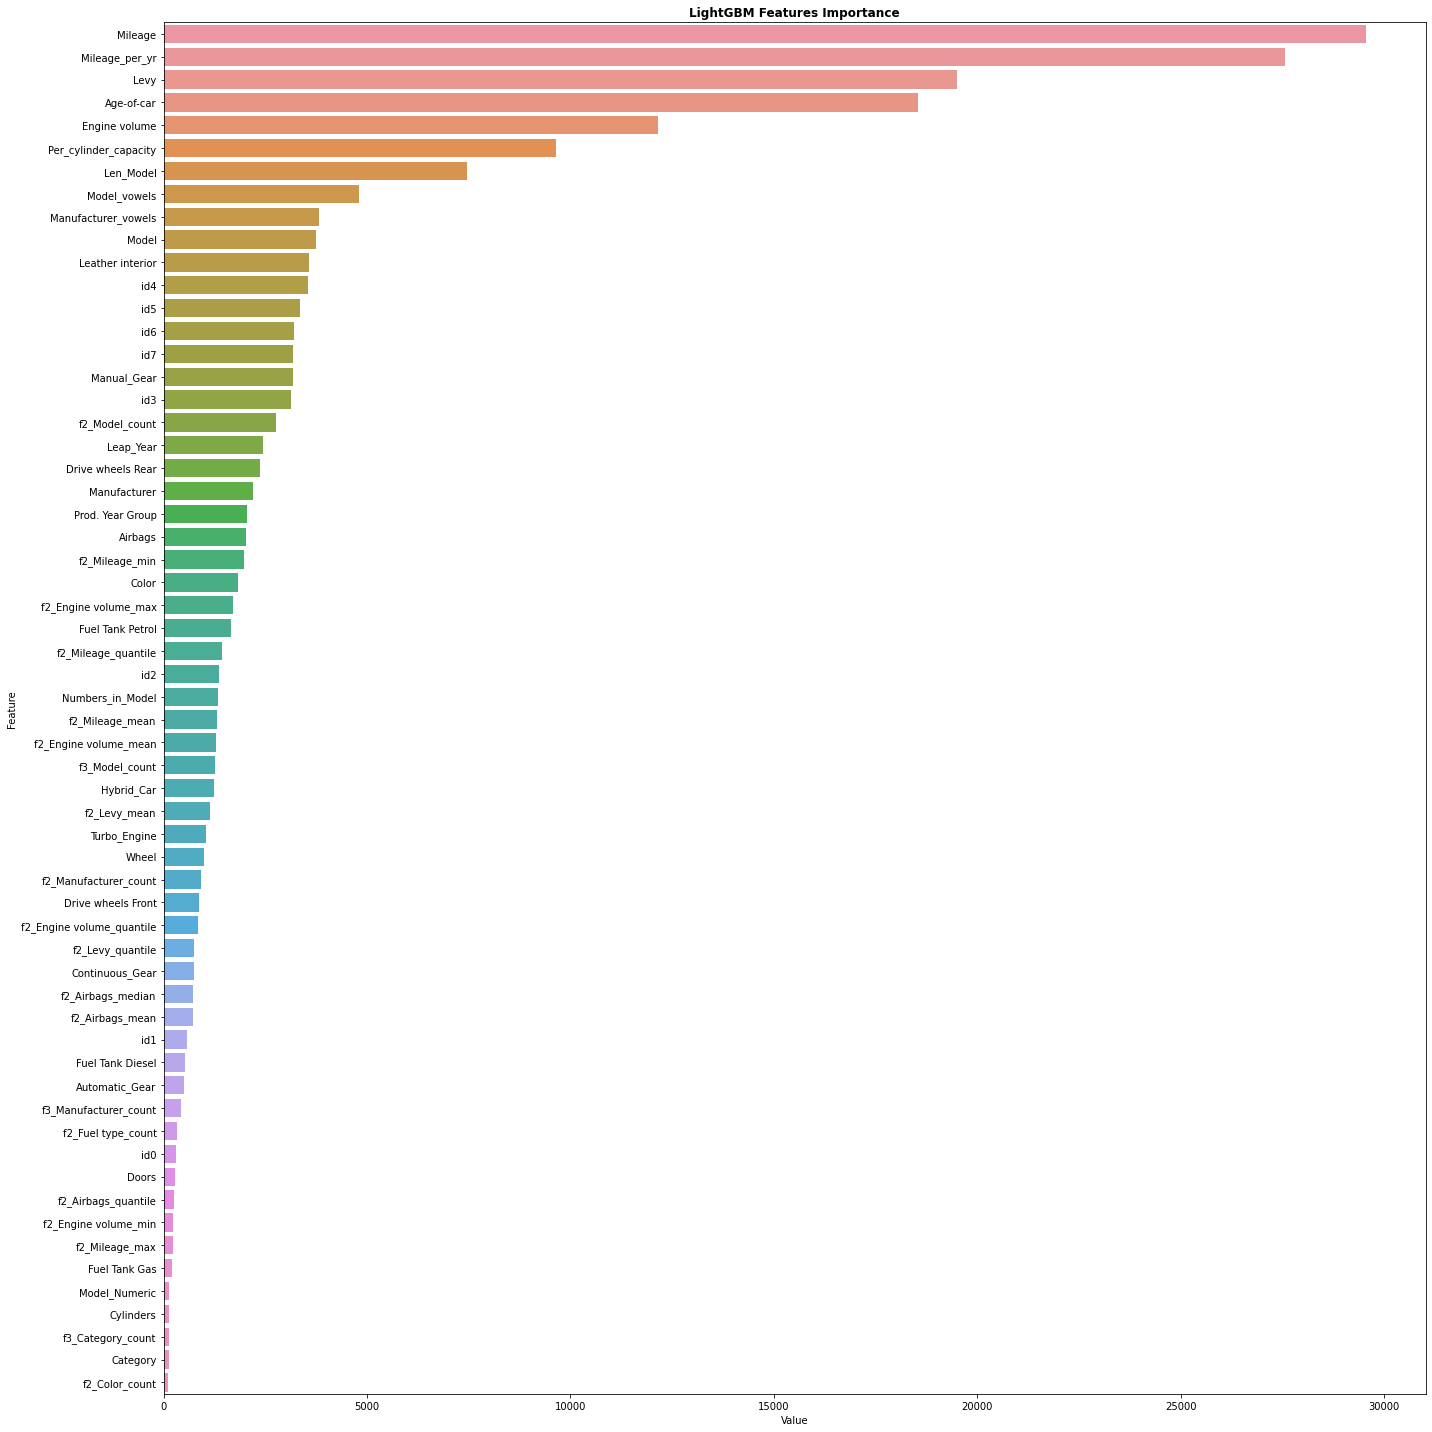

In [13]:
fet_imp = (fet_imp1 + fet_imp2)/2.0
feature_imp = pd.DataFrame(sorted(zip(fet_imp[0:60],Xtrain.columns[0:60])), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance', fontweight='bold')
plt.tight_layout()
plt.show()